In [11]:
import torch
from tqdm import tqdm_notebook as tqdm
import torchvision.models as models
import torch.nn.functional as F
import os
from DataLoader import ImageNetDataset, get_data_transform
import cv2
import torchvision.transforms as transforms
from attack import fgsm
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
%matplotlib inline

PROJ_DIR = os.getcwd()
TRAIN_VAL_PATH = os.path.join(PROJ_DIR, 'data', 'train_val')
TEST_PATH = os.path.join(PROJ_DIR, 'data', 'DAmageNet')
TRAIN_IMG_DIR = os.path.join(TRAIN_VAL_PATH, 'train')
VAL_IMG_DIR = os.path.join(TRAIN_VAL_PATH, 'val')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
with open('imagenet_classes.txt', 'r') as f:
    imagenet_classes = f.readlines()
    imagenet_classes_short = [x.strip().split(',')[-1]
                              for x in imagenet_classes]

In [13]:
def plot_top_classes(values, top_k=5):
    sorted_classes = np.argsort(-values)
    class_ids = sorted_classes[:top_k]
    class_names = [imagenet_classes_short[it] for it in list(class_ids)]
    class_values = values[class_ids]
    plt.bar(class_names, class_values)
    plt.xticks(rotation=60)

In [14]:
dataset = ImageNetDataset(TRAIN_IMG_DIR, os.path.join(TRAIN_VAL_PATH, 'train.txt'))

img, label = dataset[0]
print(imagenet_classes_short[label])

 laptop computer


In [15]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def prepare_image(image_cv2, do_normalize=True):
    # Resize
    img = cv2.resize(image_cv2, (224, 224))
    img = img[:, :, ::-1].copy()
    # Convert to tensor
    tensor_img = transforms.functional.to_tensor(img)

    # Possibly normalize
    if do_normalize:
        tensor_img = normalize(tensor_img)
    # Put image in a batch
    batch_tensor_img = torch.unsqueeze(tensor_img, 0).to(device)

    return batch_tensor_img


def UnNormalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]):
    std_arr = torch.tensor(std)[:, None, None]
    mean_arr = torch.tensor(mean)[:, None, None]

    def func(img):
        img = img.clone()
        img *= std_arr
        img += mean_arr
        return img
    return func


unnormalize = UnNormalize()


def obtain_image(tensor_img, do_normalize=True):
    tensor_img = tensor_img.cpu()
    if do_normalize:
        tensor_img = unnormalize(tensor_img)
    img = transforms.functional.to_pil_image((tensor_img.data))
    return img

In [16]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(device)
model.eval()
loss = nn.CrossEntropyLoss()
starting_img = prepare_image(img)
input_img = starting_img.clone().requires_grad_(True)

In [17]:
attacked_res = fgsm(input_img, torch.tensor([label]), model, loss, epsilon=0.3)
original_img = obtain_image(starting_img[0, :])
attacked_img = obtain_image(attacked_res[0, :])

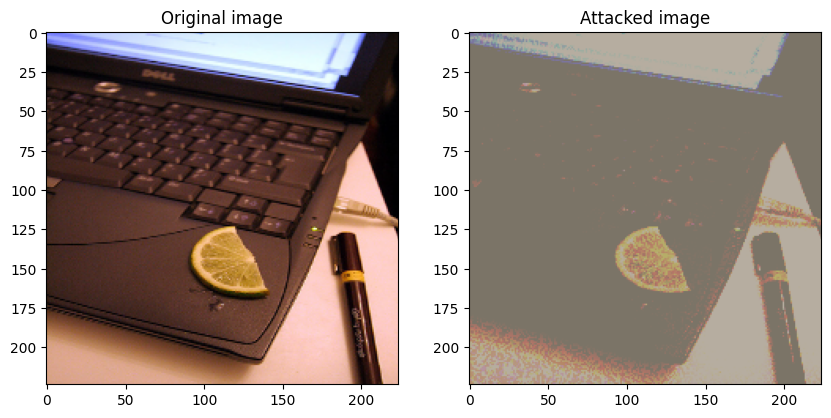

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Original image')
axs[0].imshow(original_img)
axs[1].set_title('Attacked image')
axs[1].imshow(attacked_img)

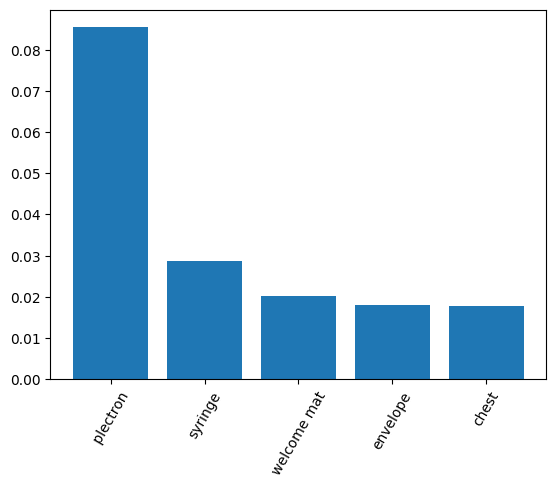

In [19]:
output = model(attacked_res)
prob = F.softmax(output, dim=1)
plot_top_classes(prob[0,:].data.cpu().numpy())